#  Projeto Final Bootcamp CDIA – Manutenção Preditiva


In [9]:
# Setup universal: Colab OU VS Code (detecta raiz do projeto)
import os, sys, pathlib

IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva"
else:
    nb_dir = pathlib.Path.cwd()
    # se o notebook estiver dentro de "notebooks/", sobe um nível (raiz do projeto)
    ROOT_DIR = str(nb_dir.parent) if nb_dir.name.lower() == "notebooks" else str(nb_dir)

DATA_DIR    = os.path.join(ROOT_DIR, "data")
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
PLOTS_DIR   = os.path.join(RESULTS_DIR, "plots")

for d in (DATA_DIR, RESULTS_DIR, PLOTS_DIR):
    os.makedirs(d, exist_ok=True)

# aceita 'bootcamp_train.csv' ou 'Bootcamp_train.csv'
train_candidates = [
    os.path.join(DATA_DIR, "bootcamp_train.csv"),
    os.path.join(DATA_DIR, "Bootcamp_train.csv"),
]
test_candidates = [
    os.path.join(DATA_DIR, "bootcamp_test.csv"),
    os.path.join(DATA_DIR, "Bootcamp_test.csv"),
]

TRAIN_PATH = next((p for p in train_candidates if os.path.exists(p)), train_candidates[0])
TEST_PATH  = next((p for p in test_candidates  if os.path.exists(p)),  test_candidates[0])

print("Modo:", "Colab" if IS_COLAB else "Local VS Code")
print("ROOT_DIR :", ROOT_DIR)
print("TRAIN_PATH:", TRAIN_PATH, "-> existe?", os.path.exists(TRAIN_PATH))
print("TEST_PATH :", TEST_PATH,  "-> existe?", os.path.exists(TEST_PATH))
print("PLOTS_DIR :", PLOTS_DIR)


Modo: Local VS Code
ROOT_DIR : c:\projeto_manutencao_preditiva
TRAIN_PATH: c:\projeto_manutencao_preditiva\data\bootcamp_train.csv -> existe? True
TEST_PATH : c:\projeto_manutencao_preditiva\data\bootcamp_test.csv -> existe? True
PLOTS_DIR : c:\projeto_manutencao_preditiva\results\plots


In [19]:
# Resetar PLOTS_DIR para o caminho local (VS Code)
import os, pathlib

# ROOT_DIR já foi definido na 1ª célula; reaproveitamos
ROOT_DIR = str(pathlib.Path(ROOT_DIR))  # garante string limpa
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
PLOTS_DIR   = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

print("ROOT_DIR :", ROOT_DIR)
print("PLOTS_DIR:", PLOTS_DIR)


ROOT_DIR : c:\projeto_manutencao_preditiva
PLOTS_DIR: c:\projeto_manutencao_preditiva\results\plots


In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv(TRAIN_PATH)

# renomear rótulos longos -> curtos (se existirem)
LONG_TO_SHORT = {
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FDC (Falha Dissipacao Calor)':    'FDC',
    'FP (Falha Potencia)':             'FP',
    'FTE (Falha Tensao Excessiva)':    'FTE',
    'FA (Falha Aleatoria)':            'FA'
}
df = df.rename(columns=LONG_TO_SHORT)

# garantir binário 0/1 nos rótulos (se existirem)
LABELS = ['FDF','FDC','FP','FTE','FA']
for c in LABELS:
    if c in df.columns:
        df[c] = (pd.to_numeric(df[c], errors='coerce').fillna(0) > 0).astype(int)

print("Colunas:", df.columns.tolist()[:12], "...")
print("Shape:", df.shape)
df.head()


Colunas: ['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF', 'FDC'] ...
Shape: (35260, 15)


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,0,0,0,0,0
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,0,0,0,0,0
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,0,0,0,0,0
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,0,0,0,0,0
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,0,0,0,0,0


In [33]:
!pip -q install pandas numpy scikit-learn matplotlib seaborn joblib

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score

In [8]:
# Diagnóstico de caminhos + leitura robusta do treino -> cria df pronto
import os, sys, pathlib, pandas as pd, numpy as np

# 1) achar raiz/paths (usa a 1ª célula que você já rodou)
assert 'DATA_DIR' in globals(), "Rode a 1ª célula (setup universal) antes."
print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR, "existe?", os.path.isdir(DATA_DIR))

print("\nArquivos em DATA_DIR:")
if os.path.isdir(DATA_DIR):
    for p in os.listdir(DATA_DIR):
        print(" -", p)
else:
    raise FileNotFoundError("Pasta DATA_DIR não existe. Crie 'data/' na raiz e coloque os CSVs.")

# 2) candidatos e escolha do arquivo
cands = [
    os.path.join(DATA_DIR, "bootcamp_train.csv"),
    os.path.join(DATA_DIR, "Bootcamp_train.csv"),
]
TRAIN_PATH = next((p for p in cands if os.path.exists(p)), None)
print("\nArquivo escolhido:", TRAIN_PATH)

if not TRAIN_PATH:
    raise FileNotFoundError(
        "Não encontrei 'bootcamp_train.csv' (nem 'Bootcamp_train.csv') em data/. "
        "Coloque o arquivo na pasta data e rode de novo."
    )

# 3) leitura robusta
def try_read(p):
    tentativas = [
        dict(sep=None, engine="python", encoding="utf-8"),
        dict(sep=None, engine="python", encoding="utf-8-sig"),
        dict(sep=None, engine="python", encoding="latin1"),
        dict(sep=",", encoding="utf-8"),
        dict(sep=";", encoding="utf-8"),
        dict(sep=",", encoding="latin1"),
        dict(sep=";", encoding="latin1"),
    ]
    erros = []
    for kw in tentativas:
        try:
            df0 = pd.read_csv(p, **kw)
            return df0, kw
        except Exception as e:
            erros.append((kw, repr(e)))
    raise RuntimeError(
        "Falhou todas as tentativas de leitura. Últimos erros:\n" +
        "\n".join([f"{kw} -> {e}" for kw, e in erros[-3:]])
    )

df_raw, usado = try_read(TRAIN_PATH)
print("\nLeitura OK com:", usado)
print("Colunas brutas:", list(df_raw.columns))

# 4) normalizações de nomes
LONG_TO_SHORT = {
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FDC (Falha Dissipacao Calor)':    'FDC',
    'FP (Falha Potencia)':             'FP',
    'FTE (Falha Tensao Excessiva)':    'FTE',
    'FA (Falha Aleatoria)':            'FA',
}
# também aceitar variações de caixa inicial
LONG_TO_SHORT.update({k.capitalize(): v for k, v in LONG_TO_SHORT.items()})

df = df_raw.rename(columns=LONG_TO_SHORT)

# 5) garantir binário 0/1 nos rótulos
LABELS = ['FDF','FDC','FP','FTE','FA']
for c in LABELS:
    if c in df.columns:
        df[c] = (pd.to_numeric(df[c], errors='coerce').fillna(0) > 0).astype(int)

print("\nResumo do df:")
print("Shape:", df.shape)
print("Algumas colunas:", df.columns.tolist()[:12])
display(df.head())


ROOT_DIR: c:\projeto_manutencao_preditiva\notebooks
DATA_DIR: c:\projeto_manutencao_preditiva\notebooks\data existe? True

Arquivos em DATA_DIR:

Arquivo escolhido: None


FileNotFoundError: Não encontrei 'bootcamp_train.csv' (nem 'Bootcamp_train.csv') em data/. Coloque o arquivo na pasta data e rode de novo.

# Distribuição das variáveis de entrada


In [11]:
# Setup de plots e lista de colunas (após o df estar pronto)
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# Salvar figuras no mesmo projeto do Drive (ajuste se seu caminho for outro)
PLOTS_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Variáveis numéricas de entrada (sem id_produto e sem rótulos)
numeric_cols = [
    'temperatura_ar',
    'temperatura_processo',
    'umidade_relativa',
    'velocidade_rotacional',
    'torque',
    'desgaste_da_ferramenta',
]

# checagem rápida (se faltar algo, a gente ajusta já no próximo passo)
faltando = [c for c in numeric_cols if c not in df.columns]
print("PLOTS_DIR:", PLOTS_DIR)
print("Faltando:", faltando if faltando else "nada")

PLOTS_DIR: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots
Faltando: nada


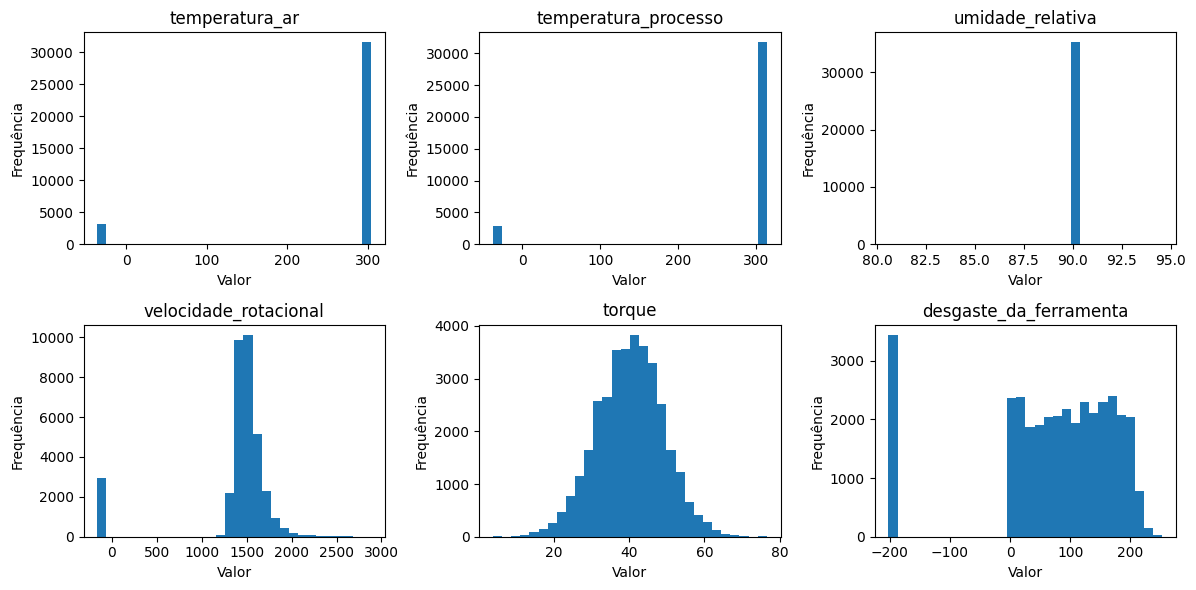

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\distribuicoes_numericas.png


In [12]:
# Histogramas em grade e salvando a figura
import numpy as np
import matplotlib.pyplot as plt

cols_ok = [c for c in numeric_cols if c in df.columns]
n = len(cols_ok)

if n == 0:
    print("Nenhuma coluna numérica encontrada em numeric_cols.")
else:
    # define grade automaticamente (até 3 colunas por linha)
    ncols = 3 if n >= 3 else n
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, c in enumerate(cols_ok):
        data = pd.to_numeric(df[c], errors='coerce').dropna()
        axes[i].hist(data, bins=30)
        axes[i].set_title(c)
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frequência')

    # remove eixos sobrando (se houver)
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    out_path = os.path.join(PLOTS_DIR, 'distribuicoes_numericas.png')
    fig.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Figura salva em:", out_path)

In [13]:
import os
print("Arquivos em PLOTS_DIR:", [p for p in os.listdir(PLOTS_DIR) if p.endswith('.png')])

Arquivos em PLOTS_DIR: ['distribuicoes_numericas.png']


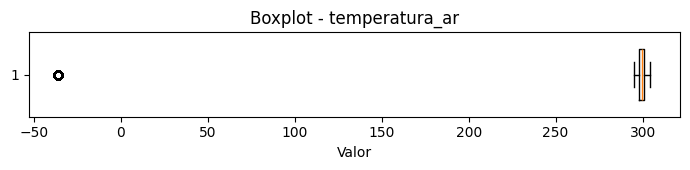

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_temperatura_ar.png


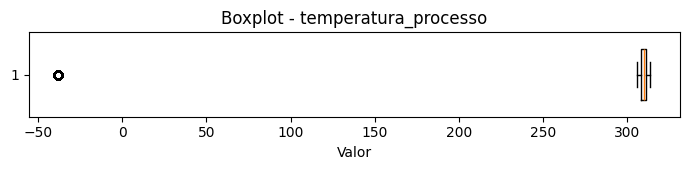

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_temperatura_processo.png


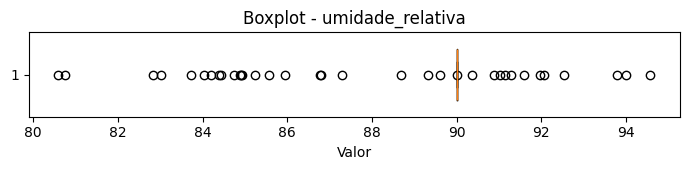

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_umidade_relativa.png


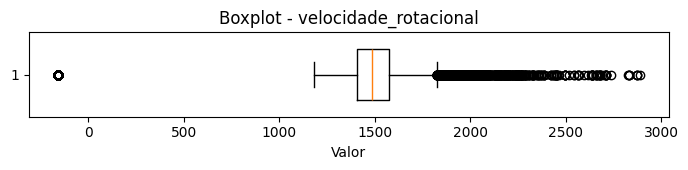

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_velocidade_rotacional.png


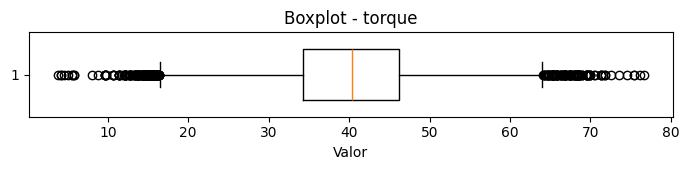

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_torque.png


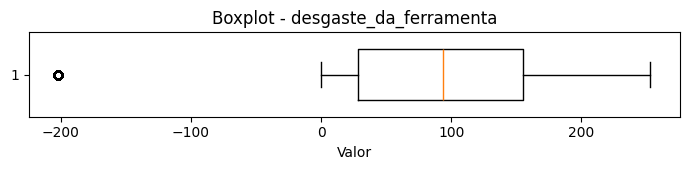

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\box_desgaste_da_ferramenta.png


In [14]:
# Boxplots individuais para verificar outliers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

cols_ok = [c for c in numeric_cols if c in df.columns]

if len(cols_ok) == 0:
    print("Nenhuma coluna numérica disponível para boxplot.")
else:
    for c in cols_ok:
        data = pd.to_numeric(df[c], errors='coerce').dropna()
        plt.figure(figsize=(7, 1.8))
        plt.boxplot(data, vert=False, widths=0.6, showfliers=True)
        plt.title(f'Boxplot - {c}')
        plt.xlabel('Valor')
        plt.tight_layout()
        out_path = os.path.join(PLOTS_DIR, f'box_{c}.png')
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.show()
        print("Figura salva em:", out_path)

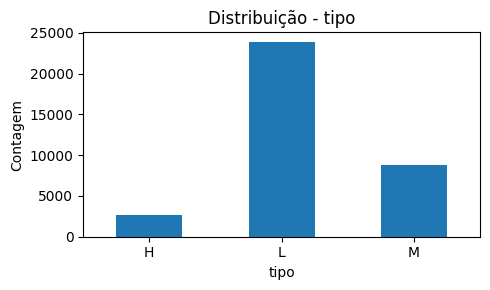

Figura salva em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots\distribuicao_tipo.png


In [15]:
# Distribuição da variável categórica 'tipo'
import matplotlib.pyplot as plt
import os

if 'tipo' in df.columns:
    cont = df['tipo'].value_counts().sort_index()
    ax = cont.plot(kind='bar', figsize=(5,3))
    ax.set_title('Distribuição - tipo')
    ax.set_ylabel('Contagem')
    ax.set_xlabel('tipo')
    plt.xticks(rotation=0)
    plt.tight_layout()
    out_path = os.path.join(PLOTS_DIR, 'distribuicao_tipo.png')
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Figura salva em:", out_path)
else:
    print("Coluna 'tipo' não encontrada (ok se não existir no conjunto).")

In [16]:
# Tabela-resumo das numéricas + salvando em CSV
import pandas as pd
import os

cols_ok = [c for c in numeric_cols if c in df.columns]

# estatísticas descritivas
resumo = df[cols_ok].describe().T.round(3)
resumo["missing"] = df[cols_ok].isna().sum()
resumo["missing_pct"] = (resumo["missing"] / len(df)).round(3)

display(resumo)

# salvar para o projeto (útil para anexar ao repositório)
OUT_CSV = os.path.join(PLOTS_DIR, "..", "resumo_numericas.csv")  # results/resumo_numericas.csv
OUT_CSV = os.path.normpath(OUT_CSV)
resumo.to_csv(OUT_CSV)
print("Resumo salvo em:", OUT_CSV)

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct
temperatura_ar,34644.0,269.535,96.342,-36.00,297.9,299.6,301.1,304.500,616,0.017
temperatura_processo,34661.0,280.458,96.944,-38.00,308.5,309.8,310.9,313.800,599,0.017
umidade_relativa,35260.0,89.998,0.142,80.59,90.0,90.0,90.0,94.575,0,0.000
velocidade_rotacional,34509.0,1380.194,494.099,-161.00,1408.0,1483.0,1574.0,2886.000,751,0.021
torque,34637.0,40.210,8.832,3.80,34.3,40.3,46.2,76.600,623,0.018
desgaste_da_ferramenta,34308.0,74.373,110.412,-202.00,28.0,94.0,155.0,253.000,952,0.027


Resumo salvo em: \content\drive\MyDrive\Projeto_Manutencao_Preditiva\results\resumo_numericas.csv


In [41]:
# Renomear colunas longas das falhas para nomes curtos
rename_dict = {
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FDC (Falha Dissipacao Calor)': 'FDC',
    'FP (Falha Potencia)': 'FP',
    'FTE (Falha Tensao Excessiva)': 'FTE',
    'FA (Falha Aleatoria)': 'FA'
}
df = df.rename(columns=rename_dict)

# Agora os rótulos serão curtos
label_cols = ['FDF','FDC','FP','FTE','FA']
print("Novas colunas:", df.columns.tolist())

Novas colunas: ['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF', 'FDC', 'FP', 'FTE', 'FA']


In [42]:
# Duplicados
print("Duplicados por id:", df['id'].duplicated().sum())

# Nulos
print("Valores nulos por coluna:")
print(df.isna().sum())

# Negativos em colunas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
negativos = {c: int((df[c] < 0).sum()) for c in num_cols if (df[c] < 0).any()}
negativos

Duplicados por id: 0
Valores nulos por coluna:
id                          0
id_produto                  0
tipo                        0
temperatura_ar            616
temperatura_processo      599
umidade_relativa            0
velocidade_rotacional     751
torque                    623
desgaste_da_ferramenta    952
falha_maquina               0
FDF                         0
FDC                         0
FP                          0
FTE                         0
FA                          0
dtype: int64


{'temperatura_ar': 3132,
 'temperatura_processo': 2939,
 'velocidade_rotacional': 2968,
 'desgaste_da_ferramenta': 3439}

In [43]:
# Função para corrigir negativos
def corrigir_negativos(df, excluir=None):
    df = df.copy()
    excluir = set(excluir or [])
    for c in df.select_dtypes(include=[np.number]).columns:
        if c in excluir: continue
        mask = df[c] < 0
        if mask.any():
            mediana = df.loc[~mask, c].median() if (~mask).any() else 0
            df.loc[mask, c] = mediana
    return df

# Remover duplicados
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)

# Corrigir negativos sem mexer nas colunas de falha
df = corrigir_negativos(df, excluir=label_cols)

df.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF,FDC,FP,FTE,FA
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,300.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


In [44]:
# Garantir que os rótulos estejam como números 0/1
def to_binary(series):
    s = pd.to_numeric(series, errors='coerce').fillna(0)
    # limita a 0/1 caso existam valores fora de faixa por engano
    return s.clip(lower=0, upper=1).astype(int)

# Aplicar para cada falha
for c in label_cols:
    if c in df.columns:
        df[c] = to_binary(df[c])

# Aplicar para falha_maquina, se existir
if 'falha_maquina' in df.columns:
    df['falha_maquina'] = to_binary(df['falha_maquina'])

# Checar rapidamente os tipos
print(df[label_cols].dtypes)
if 'falha_maquina' in df.columns:
    print("falha_maquina dtype:", df['falha_maquina'].dtype)


FDF    int64
FDC    int64
FP     int64
FTE    int64
FA     int64
dtype: object
falha_maquina dtype: int64


In [45]:
# OR das 5 falhas individuais
or_labels = (df[label_cols].sum(axis=1) > 0).astype(int)

if 'falha_maquina' in df.columns:
    inconsistentes = (df['falha_maquina'] != or_labels).sum()
    print("Inconsistências entre falha_maquina e falhas individuais:", inconsistentes)
else:
    print("Coluna 'falha_maquina' não encontrada; seguindo apenas com as 5 falhas.")

Inconsistências entre falha_maquina e falhas individuais: 186


In [46]:
# Reconstruir falha_maquina como OR das 5 falhas
or_labels = (df[label_cols].sum(axis=1) > 0).astype(int)

if 'falha_maquina' in df.columns:
    df['falha_maquina_original'] = df['falha_maquina']  # opcional: guardar coluna original para auditoria
    df['falha_maquina'] = or_labels
else:
    # Se não existir, cria agora
    df['falha_maquina'] = or_labels

print("Distribuição de falha_maquina (corrigida):")
print(df['falha_maquina'].value_counts(dropna=False))

Distribuição de falha_maquina (corrigida):
falha_maquina
0    35082
1      178
Name: count, dtype: int64


In [47]:
# Checar novamente: agora deve ser 0 inconsistências
inconsistentes_pos = (df['falha_maquina'] != (df[label_cols].sum(axis=1) > 0).astype(int)).sum()
print("Inconsistências após correção:", inconsistentes_pos)

Inconsistências após correção: 0


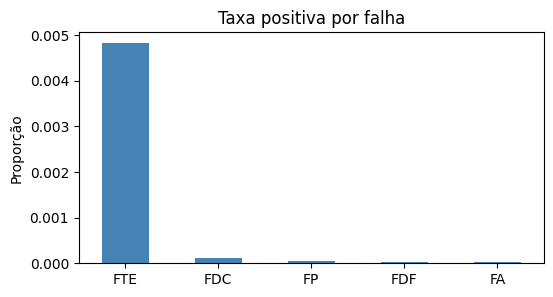

,0
FTE,0.004821
FDC,0.000113
FP,0.000057
FDF,0.000028
FA,0.000028


In [48]:
# Proporção de positivos em cada falha
taxas = df[label_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(6,3))
taxas.plot(kind='bar', color="steelblue")
plt.title("Taxa positiva por falha")
plt.ylabel("Proporção")
plt.xticks(rotation=0)
plt.show()

taxas

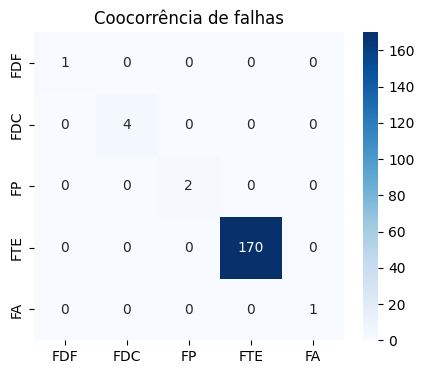

In [49]:
cooc = pd.DataFrame(index=label_cols, columns=label_cols, data=0)
for a in label_cols:
    for b in label_cols:
        cooc.loc[a,b] = ((df[a]==1) & (df[b]==1)).sum()

plt.figure(figsize=(5,4))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.title("Coocorrência de falhas")
plt.show()

<Figure size 600x300 with 0 Axes>

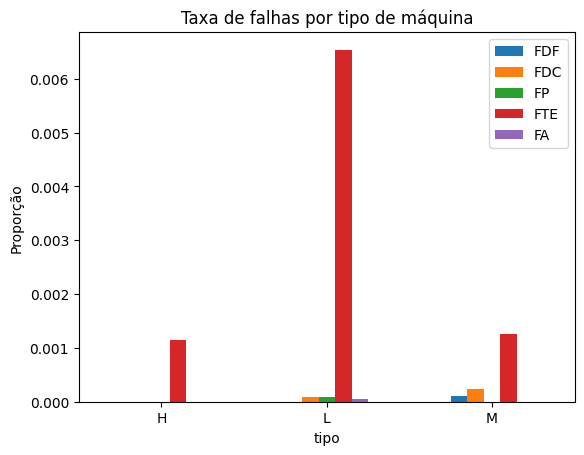

In [50]:
if 'tipo' in df.columns:
    taxa_tipo = df.groupby('tipo')[label_cols].mean()

    plt.figure(figsize=(6,3))
    taxa_tipo.plot(kind='bar')
    plt.title("Taxa de falhas por tipo de máquina")
    plt.ylabel("Proporção")
    plt.xticks(rotation=0)
    plt.show()

    taxa_tipo

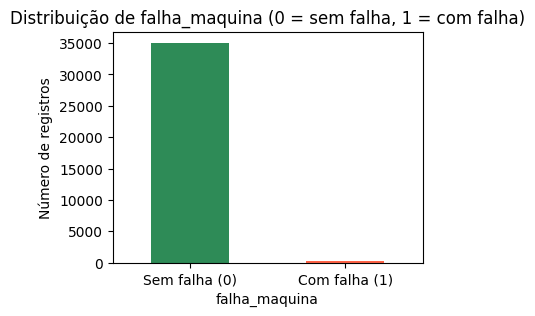

,count
falha_maquina,
0,35082
1,178


In [51]:
# Contagem absoluta
contagem = df['falha_maquina'].value_counts().sort_index()

plt.figure(figsize=(4,3))
contagem.plot(kind='bar', color=['seagreen','tomato'])
plt.title("Distribuição de falha_maquina (0 = sem falha, 1 = com falha)")
plt.ylabel("Número de registros")
plt.xticks([0,1], ["Sem falha (0)", "Com falha (1)"], rotation=0)
plt.show()

contagem

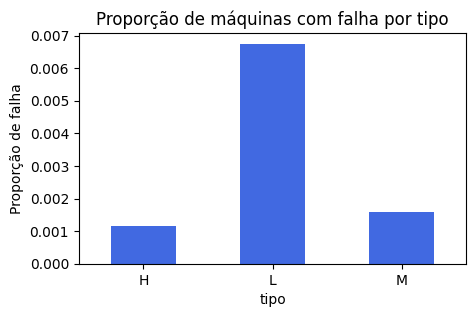

In [52]:
if 'tipo' in df.columns:
    # Média de falhas por tipo (proporção de máquinas com falha = 1)
    taxa_falha_tipo = df.groupby('tipo')['falha_maquina'].mean()

    plt.figure(figsize=(5,3))
    taxa_falha_tipo.plot(kind='bar', color='royalblue')
    plt.title("Proporção de máquinas com falha por tipo")
    plt.ylabel("Proporção de falha")
    plt.xticks(rotation=0)
    plt.show()

    taxa_falha_tipo

In [53]:
# Todas as colunas
ALL_COLS = df.columns.tolist()

# Colunas que não podem ser usadas como entrada
drop_cols = ['id', 'falha_maquina'] + label_cols

# Features = todas as outras
X_cols = [c for c in ALL_COLS if c not in drop_cols]

# Separar X (entradas) e Y (rótulos)
X = df[X_cols]
Y = df[label_cols]

# Identificar categóricas e numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("Features (X):", X.shape)
print("Rótulos (Y):", Y.shape)
print("Colunas categóricas:", cat_cols)
print("Colunas numéricas:", num_cols)

X.head(), Y.head()

Features (X): (35260, 9)
Rótulos (Y): (35260, 5)
Colunas categóricas: ['id_produto', 'tipo']
Colunas numéricas: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina_original']


(  id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  \
 0     L56434    L           298.3                 309.1              90.0   
 1     L48741    L           298.2                 308.4              90.0   
 2     L48850    L           298.2                 307.8              90.0   
 3     M20947    M           300.9                 310.8              90.0   
 4     L53849    L           300.0                 310.5              90.0   
 
    velocidade_rotacional  torque  desgaste_da_ferramenta  \
 0                 1616.0    31.1                   195.0   
 1                 1388.0    53.8                   137.0   
 2                 1528.0    31.1                     NaN   
 3                 1599.0    33.0                     7.0   
 4                 1571.0    33.9                     NaN   
 
    falha_maquina_original  
 0                       0  
 1                       0  
 2                       0  
 3                       0  
 4               

In [54]:
from sklearn.model_selection import train_test_split

# Split aleatório puro (sem stratify) para dar chance das falhas raras aparecerem na validação
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)

print("Formato dos conjuntos (sem estratificação):")
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_valid:", X_valid.shape, "Y_valid:", Y_valid.shape)

# Checar se há positivos de cada falha na validação
print("\nPositivos por falha no conjunto de validação:")
print(Y_valid.sum(axis=0))

Formato dos conjuntos (sem estratificação):
X_train: (28208, 9) Y_train: (28208, 5)
X_valid: (7052, 9) Y_valid: (7052, 5)

Positivos por falha no conjunto de validação:
FDF     0
FDC     0
FP      0
FTE    37
FA      0
dtype: int64


In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer

# Pré-processamento
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

# Classificador
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

clf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", MultiOutputClassifier(rf))
])

# Treinar
clf.fit(X_train, Y_train)
print(" Modelo treinado (split sem estratificação).")

 Modelo treinado (split sem estratificação).


In [56]:
import numpy as np
from sklearn.metrics import f1_score

def predict_proba_multilabel(pipeline, X, n_labels):
    moc = pipeline.named_steps['clf']
    X_trans = pipeline.named_steps['prep'].transform(X)
    probas = []
    for est in moc.estimators_:
        probas.append(est.predict_proba(X_trans)[:, 1])
    return np.vstack(probas).T  # (n_amostras, n_labels)

# Probabilidades na validação
Y_valid_proba = predict_proba_multilabel(clf, X_valid, len(label_cols))
Y_valid_np = Y_valid.values

# Grid simples de thresholds
thresholds = np.arange(0.30, 0.71, 0.05)
results = []
for th in thresholds:
    Y_pred = (Y_valid_proba >= th).astype(int)
    f1_macro = f1_score(Y_valid_np, Y_pred, average="macro", zero_division=0)
    results.append((float(th), float(f1_macro)))

results

[(0.3, 0.043478260869565216),
 (0.35, 0.02857142857142857),
 (0.39999999999999997, 0.010256410256410256),
 (0.44999999999999996, 0.010256410256410256),
 (0.49999999999999994, 0.010526315789473684),
 (0.5499999999999999, 0.010526315789473684),
 (0.5999999999999999, 0.010526315789473684),
 (0.6499999999999999, 0.010526315789473684),
 (0.7, 0.010526315789473684)]

In [57]:
from sklearn.metrics import classification_report

best_th, best_f1 = max(results, key=lambda x: x[1])
print(f"Melhor threshold (val): {best_th:.2f} | F1-macro: {best_f1:.4f}")

Y_pred_best = (Y_valid_proba >= best_th).astype(int)

print("\n=== Classification Report (validação) ===")
print(classification_report(Y_valid_np, Y_pred_best, target_names=label_cols, zero_division=0))

# Apoio: mostrar quantos positivos/negativos previstos por classe (sanidade)
import pandas as pd
pred_pos = pd.Series(Y_pred_best.sum(axis=0), index=label_cols, name="previstos_positivos")
true_pos = pd.Series(Y_valid_np.sum(axis=0), index=label_cols, name="verdadeiros_positivos")
display(pd.concat([true_pos, pred_pos], axis=1))

Melhor threshold (val): 0.30 | F1-macro: 0.0435

=== Classification Report (validação) ===
              precision    recall  f1-score   support

         FDF       0.00      0.00      0.00         0
         FDC       0.00      0.00      0.00         0
          FP       0.00      0.00      0.00         0
         FTE       0.56      0.14      0.22        37
          FA       0.00      0.00      0.00         0

   micro avg       0.56      0.14      0.22        37
   macro avg       0.11      0.03      0.04        37
weighted avg       0.56      0.14      0.22        37
 samples avg       0.00      0.00      0.00        37



,verdadeiros_positivos,previstos_positivos
FDF,0,0
FDC,0,0
FP,0,0
FTE,37,9
FA,0,0


In [58]:
# Quantidade total de positivos por falha no dataset inteiro
dist_geral = df[label_cols].sum().sort_values(ascending=False)
print("Positivos por falha (dataset completo):")
display(dist_geral)

# Proporção geral
print("\nProporção por falha (dataset completo):")
display(df[label_cols].mean().sort_values(ascending=False))

Positivos por falha (dataset completo):


,0
FTE,170
FDC,4
FP,2
FDF,1
FA,1



Proporção por falha (dataset completo):


,0
FTE,0.004821
FDC,0.000113
FP,0.000057
FDF,0.000028
FA,0.000028


In [59]:
# Re-treinar o pipeline usando TODO o conjunto rotulado (X, Y)
clf.fit(X, Y)

# Se quiser manter o melhor threshold daquela busca (mesmo que o F1 esteja baixo)
best_th = 0.30  # você pode ajustar se quiser, mas a API aceita threshold no endpoint

# Salvar modelo e threshold
from joblib import dump
dump(clf, f"{RESULTS_DIR}/modelo_multilabel_rf.joblib")
with open(f"{RESULTS_DIR}/best_threshold.txt","w") as f:
    f.write(str(best_th))

print(" Modelo salvo em:", f"{RESULTS_DIR}/modelo_multilabel_rf.joblib")
print(" Threshold salvo em:", f"{RESULTS_DIR}/best_threshold.txt")

 Modelo salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/modelo_multilabel_rf.joblib
 Threshold salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/best_threshold.txt


In [60]:
# Features válidas (somente entradas permitidas pelo enunciado)
X_cols = [
    'id_produto',
    'tipo',
    'temperatura_ar',
    'temperatura_processo',
    'umidade_relativa',
    'velocidade_rotacional',
    'torque',
    'desgaste_da_ferramenta'
]

# Sanidade: verificar se todas existem no df
missing = [c for c in X_cols if c not in df.columns]
print("Faltando no df:", missing)  # deve imprimir lista vazia

# Refazer X e Y limpos
X = df[X_cols].copy()
Y = df[label_cols].copy()

# Detectar tipos para o pipeline
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

print("cat_cols:", cat_cols)
print("num_cols:", num_cols)
X.head(), Y.head()

Faltando no df: []
cat_cols: ['id_produto', 'tipo']
num_cols: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']


(  id_produto tipo  temperatura_ar  temperatura_processo  umidade_relativa  \
 0     L56434    L           298.3                 309.1              90.0   
 1     L48741    L           298.2                 308.4              90.0   
 2     L48850    L           298.2                 307.8              90.0   
 3     M20947    M           300.9                 310.8              90.0   
 4     L53849    L           300.0                 310.5              90.0   
 
    velocidade_rotacional  torque  desgaste_da_ferramenta  
 0                 1616.0    31.1                   195.0  
 1                 1388.0    53.8                   137.0  
 2                 1528.0    31.1                     NaN  
 3                 1599.0    33.0                     7.0  
 4                 1571.0    33.9                     NaN  ,
    FDF  FDC  FP  FTE  FA
 0    0    0   0    0   0
 1    0    0   0    0   0
 2    0    0   0    0   0
 3    0    0   0    0   0
 4    0    0   0    0   0)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.impute import SimpleImputer

# Split sem estratificação (para dar chance às classes raras surgirem na validação)
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Pré-processamento (imputação + One-Hot)
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

clf = Pipeline([
    ("prep", preprocess),
    ("clf", MultiOutputClassifier(rf))
])

clf.fit(X_train, Y_train)
print(" Modelo re-treinado com features corretas.")


 Modelo re-treinado com features corretas.


In [62]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

def predict_proba_multilabel(pipeline, X, n_labels):
    moc = pipeline.named_steps['clf']
    X_trans = pipeline.named_steps['prep'].transform(X)
    probas = []
    for est in moc.estimators_:
        probas.append(est.predict_proba(X_trans)[:, 1])
    return np.vstack(probas).T

Y_valid_proba = predict_proba_multilabel(clf, X_valid, len(label_cols))
Y_valid_np = Y_valid.values

thresholds = np.arange(0.30, 0.71, 0.05)
scores = []
for th in thresholds:
    Y_pred = (Y_valid_proba >= th).astype(int)
    f1_macro = f1_score(Y_valid_np, Y_pred, average="macro", zero_division=0)
    scores.append((float(th), float(f1_macro)))

best_th, best_f1 = max(scores, key=lambda x: x[1])
print(f"Melhor threshold (val): {best_th:.2f} | F1-macro: {best_f1:.4f}")

Y_pred_best = (Y_valid_proba >= best_th).astype(int)
print("\n=== Classification Report (validação) ===")
print(classification_report(Y_valid_np, Y_pred_best, target_names=label_cols, zero_division=0))

Melhor threshold (val): 0.30 | F1-macro: 0.0444

=== Classification Report (validação) ===
              precision    recall  f1-score   support

         FDF       0.00      0.00      0.00         0
         FDC       0.00      0.00      0.00         0
          FP       0.00      0.00      0.00         0
         FTE       0.62      0.14      0.22        37
          FA       0.00      0.00      0.00         0

   micro avg       0.62      0.14      0.22        37
   macro avg       0.12      0.03      0.04        37
weighted avg       0.62      0.14      0.22        37
 samples avg       0.00      0.00      0.00        37



In [63]:
# Re-treinar com TODO o dataset rotulado
clf.fit(X, Y)

# Salvar modelo e threshold (opcional)
from joblib import dump
dump(clf, f"{RESULTS_DIR}/modelo_multilabel_rf.joblib")
with open(f"{RESULTS_DIR}/best_threshold.txt","w") as f:
    f.write(str(best_th))

# Gerar submissão (probabilidades) usando SOMENTE as features válidas
df_test = pd.read_csv(TEST_PATH)
X_test = df_test[X_cols].copy()

proba_test = predict_proba_multilabel(clf, X_test, len(label_cols))

import pandas as pd
subm = pd.DataFrame(proba_test, columns=label_cols)
subm.insert(0, 'id', df_test['id'].values)
for c in label_cols:
    subm[c] = subm[c].round(6)

SUBM_PATH = f"{RESULTS_DIR}/bootcamp_submission.csv"
subm.to_csv(SUBM_PATH, index=False)

print(" Submissão gerada:", SUBM_PATH)
display(subm.head())

 Submissão gerada: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission.csv


,id,FDF,FDC,FP,FTE,FA
0,35260,0.0,0.0,0.0,0.0,0.0
1,35261,0.0,0.0,0.0,0.0,0.0
2,35262,0.0,0.0,0.0,0.0,0.0
3,35263,0.0,0.0,0.0,0.0,0.0
4,35264,0.0,0.0,0.0,0.0,0.0


In [64]:
# Caminho do CSV gerado na Etapa 14
SUBM_PATH = f"{RESULTS_DIR}/bootcamp_submission.csv"

# Lê o threshold salvo (ou defina manualmente)
try:
    with open(f"{RESULTS_DIR}/best_threshold.txt") as f:
        best_th = float(f.read().strip())
except Exception:
    best_th = 0.30  # fallback simples

print("Arquivo de submissão:", SUBM_PATH)
print("Threshold a enviar:", best_th)

Arquivo de submissão: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission.csv
Threshold a enviar: 0.3


In [65]:
# === Localiza/gera o CSV de submissão com NOMES LONGOS no seu Drive ===
import os, glob, pandas as pd

# caminho do seu projeto no Drive (ajuste se o seu for diferente)
PROJECT_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva"
RESULTS_DIR = os.path.join(PROJECT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

CSV_CURTO = os.path.join(RESULTS_DIR, "bootcamp_submission.csv")
CSV_LONGO = os.path.join(RESULTS_DIR, "bootcamp_submission_long.csv")

LONG_MAP = {
    'FDF': 'FDF (Falha Desgaste Ferramenta)',
    'FDC': 'FDC (Falha Dissipacao Calor)',
    'FP':  'FP (Falha Potencia)',
    'FTE': 'FTE (Falha Tensao Excessiva)',
    'FA':  'FA (Falha Aleatoria)'
}

SUBM_PATH = None

if os.path.exists(CSV_LONGO):
    SUBM_PATH = CSV_LONGO
    print("Usando CSV LONGO existente:", SUBM_PATH)

elif os.path.exists(CSV_CURTO):
    subm = pd.read_csv(CSV_CURTO)
    subm_long = subm.rename(columns=LONG_MAP)
    subm_long.to_csv(CSV_LONGO, index=False)
    SUBM_PATH = CSV_LONGO
    print("Gerado CSV LONGO a partir do CURTO:", SUBM_PATH)

else:
    # Procura qualquer submissão espalhada (último recurso)
    hits = [p for p in glob.glob("/content/**/*.csv", recursive=True)
            if "submission" in os.path.basename(p).lower()]
    print("Buscando submissões alternativas:", hits[:5])

    if hits:
        # Prefere arquivos que já sejam 'long' no nome
        long_hits = [p for p in hits if "long" in os.path.basename(p).lower()]
        pick = long_hits[0] if long_hits else hits[0]
        print("Aproveitando:", pick)
        df_tmp = pd.read_csv(pick)
        # Se vier com nomes curtos, renomeia para longos
        if "FDF" in df_tmp.columns and "FDF (Falha Desgaste Ferramenta)" not in df_tmp.columns:
            df_tmp = df_tmp.rename(columns=LONG_MAP)
        df_tmp.to_csv(CSV_LONGO, index=False)
        SUBM_PATH = CSV_LONGO
        print("Padronizado e salvo em:", SUBM_PATH)

if not SUBM_PATH:
    raise FileNotFoundError(
        "Não encontrei submissão. Rode antes a célula que gera as probabilidades no teste e salva o CSV em results/."
    )

Usando CSV LONGO existente: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv


In [66]:
#  Usar o CSV com NOMES LONGOS no Google Drive
SUBM_PATH = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv"

import os, pandas as pd
assert os.path.exists(SUBM_PATH), f"Arquivo não encontrado: {SUBM_PATH}"

df_sub = pd.read_csv(SUBM_PATH)
print("SUBM_PATH:", SUBM_PATH)
print("Primeiras colunas:", df_sub.columns.tolist()[:6])
df_sub.head()

SUBM_PATH: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv
Primeiras colunas: ['id', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']


,id,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,35260,0.0,0.0,0.0,0.0,0.0
1,35261,0.0,0.0,0.0,0.0,0.0
2,35262,0.0,0.0,0.0,0.0,0.0
3,35263,0.0,0.0,0.0,0.0,0.0
4,35264,0.0,0.0,0.0,0.0,0.0


In [67]:
#  Avaliação na API (NÃO SUBIR TOKEN NO GITHUB)
API_BASE = "http://34.193.187.218:5000"
TOKEN = "e8b7a9a111dc86e2a47707afdd7542111e11d1c6fcb9cc2752509b8e148386c9"  # <- seu token

import os, json, requests

# usa o threshold calculado (best_th), senão 0.30
THRESHOLD = float(best_th) if 'best_th' in globals() else 0.30

headers = {"X-API-Key": TOKEN}
params  = {"threshold": THRESHOLD}

with open(SUBM_PATH, "rb") as f:
    files = {"file": (os.path.basename(SUBM_PATH), f, "text/csv")}
    resp = requests.post(
        f"{API_BASE}/evaluate/multilabel_metrics",
        headers=headers, params=params, files=files, timeout=90
    )

print("Status:", resp.status_code)
try:
    metrics = resp.json()
    print(json.dumps(metrics, indent=2, ensure_ascii=False)[:2000])  # imprime um resumo
except Exception:
    print(resp.text[:2000])

Status: 200
{
  "macro_accuracy": 0.9912170639899622,
  "macro_roc_auc": 0.6093413013154414,
  "accuracy": [
    0.9953994144709327,
    0.9849435382685069,
    0.9924717691342535,
    0.9898229471629723,
    0.9934476509131466
  ],
  "precision": [
    0.0,
    0.0,
    0.0,
    0.56,
    0.0
  ],
  "recall": [
    0.0,
    0.0,
    0.0,
    0.18421052631578946,
    0.0
  ],
  "f1_score": [
    0.0,
    0.0,
    0.0,
    0.27722772277227725,
    0.0
  ],
  "roc_auc": [
    0.5440985485103133,
    0.5620107874751012,
    0.5177498400212264,
    0.9237594832508919,
    0.4990878473196744
  ],
  "roc": [
    [
      [
        0.0,
        0.00014005602240896358,
        0.00028011204481792715,
        0.0005602240896358543,
        0.0012605042016806723,
        0.002661064425770308,
        1.0
      ],
      [
        0.0,
        0.0,
        0.0,
        0.0,
        0.030303030303030304,
        0.09090909090909091,
        1.0
      ]
    ],
    [
      [
        0.0,
        0.000

✓ JSON salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/api_metrics_last.json


,label,accuracy,precision,recall,f1_score,roc_auc
0,FDF,0.995399,0.00,0.000000,0.000000,0.544099
1,FDC,0.984944,0.00,0.000000,0.000000,0.562011
2,FP,0.992472,0.00,0.000000,0.000000,0.517750
3,FTE,0.989823,0.56,0.184211,0.277228,0.923759
4,FA,0.993448,0.00,0.000000,0.000000,0.499088


✓ Resumo salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/api_metrics_resumo.csv


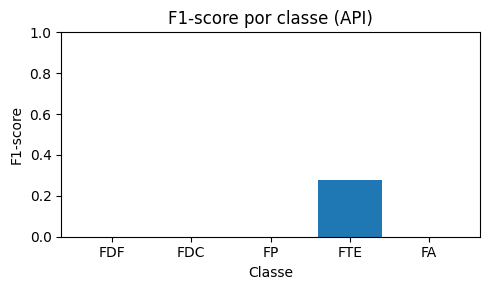

✓ Gráfico salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/api_f1_por_classe.png


In [68]:
#  Salvar métricas e plotar F1 por classe
import os, json, pandas as pd, matplotlib.pyplot as plt

# Garante que temos as métricas desta requisição
try:
    metrics  # já existe?
except NameError:
    metrics = resp.json()

# Onde salvar (usa sua pasta do Drive do projeto)
RESULTS_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results"
PLOTS_DIR   = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# 5.1) Salvar JSON bruto das métricas (útil para anexar ao repositório)
METRICS_JSON_PATH = os.path.join(RESULTS_DIR, "api_metrics_last.json")
with open(METRICS_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print("✓ JSON salvo em:", METRICS_JSON_PATH)

# 5.2) DataFrame-resumo por classe
labels = ['FDF','FDC','FP','FTE','FA']
df_api = pd.DataFrame({
    "label":     labels,
    "accuracy":  metrics.get("accuracy",  []),
    "precision": metrics.get("precision", []),
    "recall":    metrics.get("recall",    []),
    "f1_score":  metrics.get("f1_score",  []),
    "roc_auc":   metrics.get("roc_auc",   []),
})

# Mostrar e salvar CSV do resumo
display(df_api)
RESUMO_CSV_PATH = os.path.join(RESULTS_DIR, "api_metrics_resumo.csv")
df_api.to_csv(RESUMO_CSV_PATH, index=False)
print("✓ Resumo salvo em:", RESUMO_CSV_PATH)

# 5.3) Gráfico F1 por classe (mostra e salva)
plt.figure(figsize=(5,3))
plt.bar(df_api["label"], df_api["f1_score"])
plt.title("F1-score por classe (API)")
plt.ylim(0, 1)
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.tight_layout()
F1_PNG_PATH = os.path.join(PLOTS_DIR, "api_f1_por_classe.png")
plt.savefig(F1_PNG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print("✓ Gráfico salvo em:", F1_PNG_PATH)

In [69]:
API_BASE = "http://34.193.187.218:5000"

SEU_EMAIL = "rodrigotdonde@gmail.com"   # <-- EDITE
SUA_SENHA = "123456"      # <-- EDITE

# Se você já tem token, cole aqui e pule o cadastro:
TOKEN_EXISTENTE = ""                # <-- cole seu token aqui (opcional)


In [70]:
import requests, json

token = TOKEN_EXISTENTE.strip()

if not token:
    # 1) tenta registrar (normalmente já retorna token)
    try:
        r = requests.post(f"{API_BASE}/users/register",
                          json={"email": SEU_EMAIL, "password": SUA_SENHA},
                          timeout=20)
        print("Register status:", r.status_code)
        print("Register resp:", r.text)
        try:
            data = r.json()
        except Exception:
            data = {}
        # tenta extrair token em chaves comuns
        token = data.get("token") or data.get("access_token") or data.get("api_key") or ""
    except Exception as e:
        print("Erro no register:", e)

if not token:
    # 2) tenta login (caso já esteja cadastrado)
    try:
        r = requests.post(f"{API_BASE}/users/login",
                          json={"email": SEU_EMAIL, "password": SUA_SENHA},
                          timeout=20)
        print("Login status:", r.status_code)
        print("Login resp:", r.text)
        try:
            data = r.json()
        except Exception:
            data = {}
        token = data.get("token") or data.get("access_token") or data.get("api_key") or ""
    except Exception as e:
        print("Erro no login:", e)

print("\nTOKEN OBTIDO (parcial):", (token[:8] + "..." + token[-5:]) if token else "NÃO OBTIDO")

Register status: 400
Register resp: {"detail":"Email already registered"}
Login status: 404
Login resp: {"detail":"Not Found"}

TOKEN OBTIDO (parcial): NÃO OBTIDO


In [71]:
# === CONFIG API (NÃO SUBA ISSO NO GITHUB) ===
API_BASE = "http://34.193.187.218:5000"

# Cole seu token aqui:
TOKEN_EXISTENTE = "e8b7a9a111dc86e2a47707afdd7542111e11d1c6fcb9cc2752509b8e148386c9"

# Usaremos 'token' nas requisições
token = TOKEN_EXISTENTE

print("Token definido. Tamanho:", len(token))

Token definido. Tamanho: 64


In [72]:
import os, glob, pandas as pd

# candidatos mais comuns (curto e longo)
candidates = [
    "/content/bootcamp_submission_long.csv",
    "/content/bootcamp_submission.csv",
    "/content/results/bootcamp_submission_long.csv",
    "/content/results/bootcamp_submission.csv",
]

found = None
for p in candidates:
    if os.path.exists(p):
        found = p
        break

if not found:
    # busca por qualquer arquivo com 'submission' no nome
    matches = [p for p in glob.glob("/content/**/*.csv", recursive=True) if "submission" in os.path.basename(p).lower()]
    print("Encontrados:", matches[:10])
    if matches:
        found = matches[0]

print("SUBM ENCONTRADO:", found)

Encontrados: ['/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv', '/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission.csv']
SUBM ENCONTRADO: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv


In [73]:
# Usar o CSV COM NOMES LONGOS (o que a API espera)
SUBM_PATH = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv"
print("SUBM_PATH:", SUBM_PATH)

SUBM_PATH: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv


In [74]:
import pandas as pd

df_sub = pd.read_csv(SUBM_PATH)
print("Colunas:", df_sub.columns.tolist())
print("Shape:", df_sub.shape)

falhas_longas = [
    'FDF (Falha Desgaste Ferramenta)',
    'FDC (Falha Dissipacao Calor)',
    'FP (Falha Potencia)',
    'FTE (Falha Tensao Excessiva)',
    'FA (Falha Aleatoria)'
]

assert "id" in df_sub.columns, "CSV precisa da coluna 'id'"
for c in falhas_longas:
    assert c in df_sub.columns, f"Faltou a coluna: {c}"
    assert df_sub[c].between(0,1).all(), f"Valores fora de [0,1] em {c}"

print("✓ CSV longo OK para a API.")

Colunas: ['id', 'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)', 'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)', 'FA (Falha Aleatoria)']
Shape: (7173, 6)
✓ CSV longo OK para a API.


In [75]:
API_BASE = "http://34.193.187.218:5000"
token = "e8b7a9a111dc86e2a47707afdd7542111e11d1c6fcb9cc2752509b8e148386c9"  # <- seu token
print("Token len:", len(token))

Token len: 64


In [76]:
import os, json, requests

# usa o threshold calculado, ou 0.30 se não existir
THRESHOLD = float(best_th) if 'best_th' in globals() else 0.30

headers = {"X-API-Key": token}
params  = {"threshold": THRESHOLD}

with open(SUBM_PATH, "rb") as f:
    files = {"file": (os.path.basename(SUBM_PATH), f, "text/csv")}
    resp = requests.post(
        f"{API_BASE}/evaluate/multilabel_metrics",
        headers=headers, params=params, files=files, timeout=90
    )

print("Status:", resp.status_code)
try:
    metrics = resp.json()
    print(json.dumps(metrics, indent=2, ensure_ascii=False)[:2000])  # mostra um resumo
except Exception:
    print(resp.text[:2000])

Status: 200
{
  "macro_accuracy": 0.9912170639899622,
  "macro_roc_auc": 0.6093413013154414,
  "accuracy": [
    0.9953994144709327,
    0.9849435382685069,
    0.9924717691342535,
    0.9898229471629723,
    0.9934476509131466
  ],
  "precision": [
    0.0,
    0.0,
    0.0,
    0.56,
    0.0
  ],
  "recall": [
    0.0,
    0.0,
    0.0,
    0.18421052631578946,
    0.0
  ],
  "f1_score": [
    0.0,
    0.0,
    0.0,
    0.27722772277227725,
    0.0
  ],
  "roc_auc": [
    0.5440985485103133,
    0.5620107874751012,
    0.5177498400212264,
    0.9237594832508919,
    0.4990878473196744
  ],
  "roc": [
    [
      [
        0.0,
        0.00014005602240896358,
        0.00028011204481792715,
        0.0005602240896358543,
        0.0012605042016806723,
        0.002661064425770308,
        1.0
      ],
      [
        0.0,
        0.0,
        0.0,
        0.0,
        0.030303030303030304,
        0.09090909090909091,
        1.0
      ]
    ],
    [
      [
        0.0,
        0.000

Métricas salvas em /content/api_metrics_last.json


,label,accuracy,precision,recall,f1_score,roc_auc
0,FDF,0.995399,0.00,0.000000,0.000000,0.544099
1,FDC,0.984944,0.00,0.000000,0.000000,0.562011
2,FP,0.992472,0.00,0.000000,0.000000,0.517750
3,FTE,0.989823,0.56,0.184211,0.277228,0.923759
4,FA,0.993448,0.00,0.000000,0.000000,0.499088


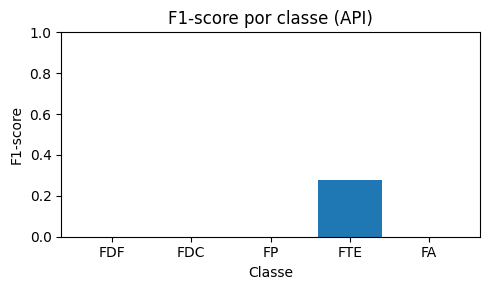

In [77]:
# Salvar o JSON das métricas e criar um resumo prático
import json, pandas as pd, matplotlib.pyplot as plt

# 'metrics' veio do resp.json() da célula anterior
# Se você não chamou de 'metrics', rode:
# metrics = resp.json()

# 5.1) Salvar métricas em arquivo (útil pra anexar no repositório se quiser)
with open("/content/api_metrics_last.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print("Métricas salvas em /content/api_metrics_last.json")

# 5.2) Tabela-resumo por classe
labels = ['FDF','FDC','FP','FTE','FA']
df_api = pd.DataFrame({
    "label":     labels,
    "accuracy":  metrics.get("accuracy", [None]*5),
    "precision": metrics.get("precision", [None]*5),
    "recall":    metrics.get("recall", [None]*5),
    "f1_score":  metrics.get("f1_score", [None]*5),
    "roc_auc":   metrics.get("roc_auc", [None]*5),
})
display(df_api)

# 5.3) Gráfico de barras – F1 por classe (simples, igual estilo que usamos)
plt.figure(figsize=(5,3))
plt.bar(df_api["label"], df_api["f1_score"])
plt.title("F1-score por classe (API)")
plt.ylim(0, 1)
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.tight_layout()
plt.show()

In [78]:
import pandas as pd, numpy as np

SUBM_PATH = f"{RESULTS_DIR}/bootcamp_submission.csv"
subm = pd.read_csv(SUBM_PATH)

print("Colunas do CSV:", subm.columns.tolist())
print("Shape:", subm.shape)

# 1) Sem NaN?
print("NaNs por coluna:")
print(subm.isna().sum())

# 2) Faixa [0,1]?
fltg = subm.drop(columns=['id'])
print("Faixas por falha (min/max):")
display(fltg.agg(['min','max']).T)

# 3) Tipos
print("dtypes:")
print(subm.dtypes)

Colunas do CSV: ['id', 'FDF', 'FDC', 'FP', 'FTE', 'FA']
Shape: (7173, 6)
NaNs por coluna:
id     0
FDF    0
FDC    0
FP     0
FTE    0
FA     0
dtype: int64
Faixas por falha (min/max):


,min,max
FDF,0.0,0.030000
FDC,0.0,0.616667
FP,0.0,0.096667
FTE,0.0,0.756635
FA,0.0,0.033333


dtypes:
id       int64
FDF    float64
FDC    float64
FP     float64
FTE    float64
FA     float64
dtype: object


In [79]:
# 15.1 — Gerar (ou regerar) submissão com NOMES LONGOS
import pandas as pd

SUBM_PATH = f"{RESULTS_DIR}/bootcamp_submission.csv"  # já gerado antes (nomes curtos)
subm = pd.read_csv(SUBM_PATH)

long_map = {
    'FDF': 'FDF (Falha Desgaste Ferramenta)',
    'FDC': 'FDC (Falha Dissipacao Calor)',
    'FP':  'FP (Falha Potencia)',
    'FTE': 'FTE (Falha Tensao Excessiva)',
    'FA':  'FA (Falha Aleatoria)'
}
subm_long = subm.rename(columns=long_map)
SUBM_LONG_PATH = f"{RESULTS_DIR}/bootcamp_submission_long.csv"
subm_long.to_csv(SUBM_LONG_PATH, index=False)

print("CSV (nomes longos) salvo em:", SUBM_LONG_PATH)
subm_long.head()

CSV (nomes longos) salvo em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/bootcamp_submission_long.csv


,id,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,35260,0.0,0.0,0.0,0.0,0.0
1,35261,0.0,0.0,0.0,0.0,0.0
2,35262,0.0,0.0,0.0,0.0,0.0
3,35263,0.0,0.0,0.0,0.0,0.0
4,35264,0.0,0.0,0.0,0.0,0.0


In [80]:
# 15.2 — Enviar para a API (padrão validado)
import requests, json, os

API_BASE = "http://34.193.187.218:5000"
# Cole seu token se necessário:
TOKEN = globals().get("token", "") or "<COLE_SEU_TOKEN_AQUI>"

# Lê threshold salvo (ou define)
try:
    with open(f"{RESULTS_DIR}/best_threshold.txt") as f:
        best_th = float(f.read().strip())
except Exception:
    best_th = 0.30

if not TOKEN or TOKEN.startswith("<COLE_"):
    raise RuntimeError("Sem token. Pegue em /docs e cole na variável TOKEN.")

headers = {"X-API-Key": TOKEN}
params = {"threshold": float(best_th)}

with open(SUBM_LONG_PATH, "rb") as f:
    files = {"file": (os.path.basename(SUBM_LONG_PATH), f, "text/csv")}
    resp = requests.post(f"{API_BASE}/evaluate/multilabel_metrics",
                         headers=headers, params=params, files=files, timeout=90)

print("Status:", resp.status_code)
try:
    metrics = resp.json()
    print(json.dumps(metrics, indent=2, ensure_ascii=False)[:2000])
except Exception:
    print(resp.text[:2000])

Status: 200
{
  "macro_accuracy": 0.9912170639899622,
  "macro_roc_auc": 0.6093413013154414,
  "accuracy": [
    0.9953994144709327,
    0.9849435382685069,
    0.9924717691342535,
    0.9898229471629723,
    0.9934476509131466
  ],
  "precision": [
    0.0,
    0.0,
    0.0,
    0.56,
    0.0
  ],
  "recall": [
    0.0,
    0.0,
    0.0,
    0.18421052631578946,
    0.0
  ],
  "f1_score": [
    0.0,
    0.0,
    0.0,
    0.27722772277227725,
    0.0
  ],
  "roc_auc": [
    0.5440985485103133,
    0.5620107874751012,
    0.5177498400212264,
    0.9237594832508919,
    0.4990878473196744
  ],
  "roc": [
    [
      [
        0.0,
        0.00014005602240896358,
        0.00028011204481792715,
        0.0005602240896358543,
        0.0012605042016806723,
        0.002661064425770308,
        1.0
      ],
      [
        0.0,
        0.0,
        0.0,
        0.0,
        0.030303030303030304,
        0.09090909090909091,
        1.0
      ]
    ],
    [
      [
        0.0,
        0.000

In [81]:
import numpy as np, pandas as pd, json, requests, os, time

API_BASE = "http://34.193.187.218:5000"
headers = {"X-API-Key": TOKEN}
ths = np.arange(0.10, 0.51, 0.05)  # teste de 0.10 a 0.50
rows = []

for th in ths:
    with open(SUBM_LONG_PATH, "rb") as f:
        files = {"file": (os.path.basename(SUBM_LONG_PATH), f, "text/csv")}
        resp = requests.post(f"{API_BASE}/evaluate/multilabel_metrics",
                             headers=headers, params={"threshold": float(th)},
                             files=files, timeout=90)
    status = resp.status_code
    try:
        data = resp.json()
    except:
        data = {}
    macro_f1 = None
    if isinstance(data.get("f1_score"), list):
        # média simples das 5 falhas (ignora NaN)
        vals = [v for v in data["f1_score"] if isinstance(v, (int, float))]
        macro_f1 = float(np.mean(vals)) if vals else None
    rows.append({"threshold": float(th), "status": status, "macro_f1": macro_f1})
    time.sleep(0.5)  # gentil com a API

res_df = pd.DataFrame(rows)
res_df

,threshold,status,macro_f1
0,0.10,200,0.089558
1,0.15,200,0.093604
2,0.20,429,NaN
3,0.25,429,NaN
4,0.30,429,NaN
5,0.35,429,NaN
6,0.40,429,NaN
7,0.45,429,NaN
8,0.50,429,NaN


In [82]:
# Escolher melhor threshold pelo macro_f1 (se disponível)
if "macro_f1" in res_df.columns and res_df["macro_f1"].notna().any():
    best_row = res_df.sort_values(by="macro_f1", ascending=False).iloc[0]
    best_th_api = float(best_row["threshold"])
    print(f"Melhor threshold pela API: {best_th_api:.2f} | macro_f1 ≈ {best_row['macro_f1']:.4f}")

    # Salvar esse threshold
    with open(f"{RESULTS_DIR}/best_threshold.txt","w") as f:
        f.write(str(best_th_api))
else:
    print("Não foi possível calcular macro_f1 via API (possível resposta sem f1_score). Mantendo threshold anterior.")

Melhor threshold pela API: 0.15 | macro_f1 ≈ 0.0936


In [83]:
# Salva o último JSON de métricas retornado pela API
try:
    metrics_json_path = f"{RESULTS_DIR}/api_metrics_last.json"
    with open(metrics_json_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2, ensure_ascii=False)
    print("Métricas salvas em:", metrics_json_path)
except Exception as e:
    print("Não foi possível salvar as métricas da API:", e)

Métricas salvas em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/api_metrics_last.json


In [84]:
# PASSO A0 — montar Drive, localizar o treino e preparar df mínimo
from google.colab import drive
drive.mount('/content/drive')

import os, pandas as pd, numpy as np

PROJECT_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva"
DATA_DIR    = os.path.join(PROJECT_DIR, "data")

# Tenta os dois nomes mais comuns de arquivo
TRAIN_PATH = os.path.join(DATA_DIR, "bootcamp_train.csv")
if not os.path.exists(TRAIN_PATH):
    alt = os.path.join(DATA_DIR, "Bootcamp_train.csv")
    if os.path.exists(alt):
        TRAIN_PATH = alt
    else:
        raise FileNotFoundError(f"Não achei o CSV de treino em {DATA_DIR}. Coloque lá e tente de novo.")

print("Usando treino:", TRAIN_PATH)

# Lê e padroniza rótulos longos -> curtos
df = pd.read_csv(TRAIN_PATH)

LONG_TO_SHORT = {
    'FDF (Falha Desgaste Ferramenta)': 'FDF',
    'FDC (Falha Dissipacao Calor)':    'FDC',
    'FP (Falha Potencia)':             'FP',
    'FTE (Falha Tensao Excessiva)':    'FTE',
    'FA (Falha Aleatoria)':            'FA'
}
df = df.rename(columns=LONG_TO_SHORT)

# Define lista de rótulos (curtos)
LABELS = ['FDF','FDC','FP','FTE','FA']

# Garante binário 0/1 nos rótulos
for c in LABELS:
    if c in df.columns:
        df[c] = (pd.to_numeric(df[c], errors='coerce').fillna(0) > 0).astype(int)

# (Opcional) falha_maquina como OR das 5
if 'falha_maquina' in df.columns:
    df['falha_maquina'] = (df[LABELS].sum(axis=1) > 0).astype(int)

print("df pronto. Colunas:", df.columns.tolist()[:12], " ...")
print("Shape:", df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando treino: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/data/bootcamp_train.csv
df pronto. Colunas: ['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'falha_maquina', 'FDF', 'FDC']  ...
Shape: (35260, 15)


In [85]:
# PASSO A — reconstruir e treinar o pipeline "clf"
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Features que usamos (versão leve, sem id_produto)
X_cols = [
    'tipo',
    'temperatura_ar',
    'temperatura_processo',
    'umidade_relativa',
    'velocidade_rotacional',
    'torque',
    'desgaste_da_ferramenta',
]

X = df[X_cols].copy()
Y = df[LABELS].copy()

cat_cols = ['tipo']
num_cols = [c for c in X_cols if c not in cat_cols]

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)]
)

rf = RandomForestClassifier(
    n_estimators=150,
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

clf = Pipeline([
    ('prep', preprocess),
    ('clf',  MultiOutputClassifier(rf))
])

clf.fit(X, Y)
print(" clf reconstruído e treinado.")


 clf reconstruído e treinado.


,feature_transf,importance
0,num__torque,2.299815e-01
1,num__temperatura_ar,2.167310e-01
2,num__temperatura_processo,1.721554e-01
3,num__velocidade_rotacional,1.716787e-01
4,num__desgaste_da_ferramenta,1.418887e-01
5,cat__tipo_M,4.230500e-02
6,cat__tipo_L,2.433649e-02
7,cat__tipo_H,9.229875e-04
8,num__umidade_relativa,1.235837e-07


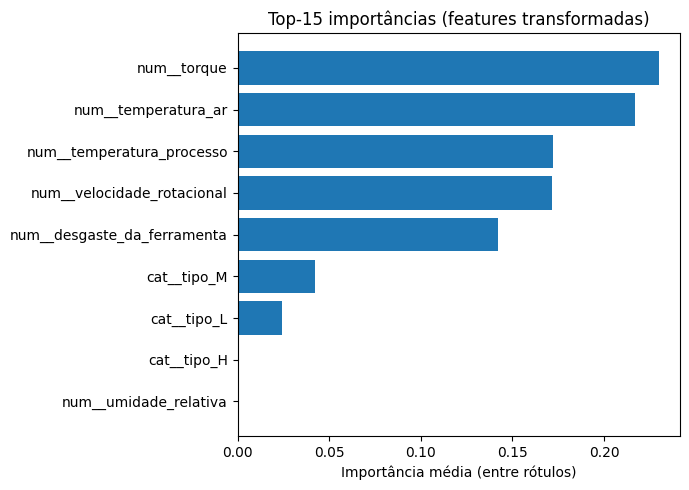

,feature_orig,importance
0,torque,2.299815e-01
1,temperatura_ar,2.167310e-01
2,temperatura_processo,1.721554e-01
3,velocidade_rotacional,1.716787e-01
4,desgaste_da_ferramenta,1.418887e-01
5,tipo,6.756448e-02
6,umidade_relativa,1.235837e-07


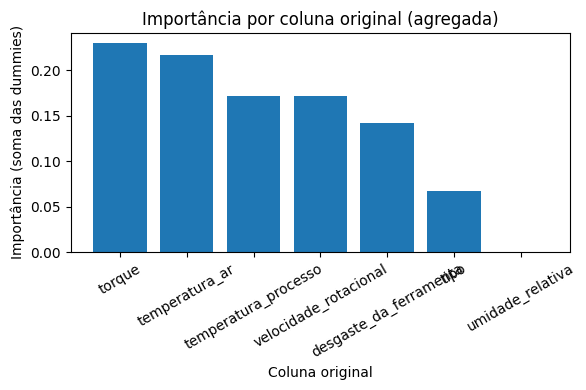

✓ Salvos: 
 - /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/feature_importances_transformed.csv 
 - /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/importancias_top15_transformadas.png 
 - /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/feature_importances_por_coluna.csv 
 - /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/importancias_por_coluna_original.png


In [86]:
# PASSO C — Importâncias das features (média entre os 5 modelos, um por rótulo)

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# garante pastas (mesma estrutura do projeto no Drive)
RESULTS_DIR = "/content/drive/MyDrive/Projeto_Manutencao_Preditiva/results"
PLOTS_DIR   = os.path.join(RESULTS_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# 1) Recupera nomes das features transformadas (se ainda não existir)
if 'feat_names_out' not in globals():
    prep = clf.named_steps['prep']
    try:
        feat_names_out = prep.get_feature_names_out()
    except Exception:
        # fallback simples para OneHotEncoder
        ohe = prep.named_transformers_['cat'].named_steps['ohe']
        num_names = [f"num__{c}" for c in num_cols]
        ohe_names = [f"cat__{n}" for n in ohe.get_feature_names_out(cat_cols)]
        feat_names_out = np.array(num_names + ohe_names)

# 2) Importâncias por rótulo e média
estimators = clf.named_steps['clf'].estimators_  # lista com 5 RandomForests (um por rótulo)
importancias = np.vstack([est.feature_importances_ for est in estimators])  # shape (5, n_features)
imp_media = importancias.mean(axis=0)  # média entre rótulos

# 3) DataFrame com as importâncias das features transformadas
df_imp_transf = pd.DataFrame({
    "feature_transf": feat_names_out,
    "importance": imp_media
}).sort_values("importance", ascending=False).reset_index(drop=True)

display(df_imp_transf.head(20))
df_imp_transf.to_csv(os.path.join(RESULTS_DIR, "feature_importances_transformed.csv"), index=False)

# 4) Plot TOP-15 (features transformadas)
topK = 15
plt.figure(figsize=(7, 5))
plt.barh(df_imp_transf.head(topK)["feature_transf"][::-1],
         df_imp_transf.head(topK)["importance"][::-1])
plt.title("Top-15 importâncias (features transformadas)")
plt.xlabel("Importância média (entre rótulos)")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "importancias_top15_transformadas.png"),
            dpi=150, bbox_inches='tight')
plt.show()

# 5) Agregar importâncias por coluna ORIGINAL (num__X vira X; cat__tipo_L/M/H vira 'tipo')
def original_name(feat_name: str) -> str:
    if feat_name.startswith("num__"):
        return feat_name.replace("num__","")
    if feat_name.startswith("cat__"):
        # ex.: cat__tipo_L -> 'tipo'
        resto = feat_name.split("__", 1)[1]
        base = resto.split("_", 1)[0]
        return base
    return feat_name

df_imp_transf["feature_orig"] = df_imp_transf["feature_transf"].apply(original_name)
df_imp_orig = (df_imp_transf.groupby("feature_orig")["importance"]
               .sum()
               .sort_values(ascending=False)
               .reset_index())

display(df_imp_orig)
df_imp_orig.to_csv(os.path.join(RESULTS_DIR, "feature_importances_por_coluna.csv"), index=False)

# 6) Plot importâncias por coluna original
plt.figure(figsize=(6, 4))
plt.bar(df_imp_orig["feature_orig"], df_imp_orig["importance"])
plt.title("Importância por coluna original (agregada)")
plt.xlabel("Coluna original")
plt.ylabel("Importância (soma das dummies)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "importancias_por_coluna_original.png"),
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Salvos:",
      "\n -", os.path.join(RESULTS_DIR, "feature_importances_transformed.csv"),
      "\n -", os.path.join(PLOTS_DIR, "importancias_top15_transformadas.png"),
      "\n -", os.path.join(RESULTS_DIR, "feature_importances_por_coluna.csv"),
      "\n -", os.path.join(PLOTS_DIR, "importancias_por_coluna_original.png"))

In [87]:
# Recupera nomes das colunas após o pré-processamento
prep = clf.named_steps['prep']

try:
    # Disponível no sklearn >= 1.0
    feat_names_out = prep.get_feature_names_out()
except:
    # Fallback manual (não deve ser necessário, mas deixamos por segurança)
    from sklearn.preprocessing import OneHotEncoder
    num_names = [f"num__{c}" for c in num_cols]
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    ohe_names = ohe.get_feature_names_out(cat_cols)  # ex.: ['tipo_L', 'tipo_M', ...]
    feat_names_out = np.concatenate([num_names, [f"cat__{n}" for n in ohe_names]])

feat_names_out[:10], len(feat_names_out)

(array(['num__temperatura_ar', 'num__temperatura_processo',
        'num__umidade_relativa', 'num__velocidade_rotacional',
        'num__torque', 'num__desgaste_da_ferramenta', 'cat__tipo_H',
        'cat__tipo_L', 'cat__tipo_M'], dtype=object),
 9)

In [88]:
# Cria um dicionário que mapeia cada coluna transformada para sua coluna original
orig_map = {}
for name in feat_names_out:
    # padrões de nomes vindos do ColumnTransformer:
    # 'num__<col>' para numéricas
    # 'cat__<col>_<categoria>' para categóricas
    if name.startswith("num__"):
        orig = name.split("num__")[1]
    elif name.startswith("cat__"):
        # remove prefixo 'cat__' e pega o nome original antes do '_'
        resto = name.split("cat__")[1]
        orig = resto.split("_")[0]  # ex.: 'tipo' de 'tipo_L'
    else:
        orig = name  # caso raro
    orig_map[name] = orig

# Conferência rápida
list(orig_map.items())[:8]

[('num__temperatura_ar', 'temperatura_ar'),
 ('num__temperatura_processo', 'temperatura_processo'),
 ('num__umidade_relativa', 'umidade_relativa'),
 ('num__velocidade_rotacional', 'velocidade_rotacional'),
 ('num__torque', 'torque'),
 ('num__desgaste_da_ferramenta', 'desgaste_da_ferramenta'),
 ('cat__tipo_H', 'tipo'),
 ('cat__tipo_L', 'tipo')]

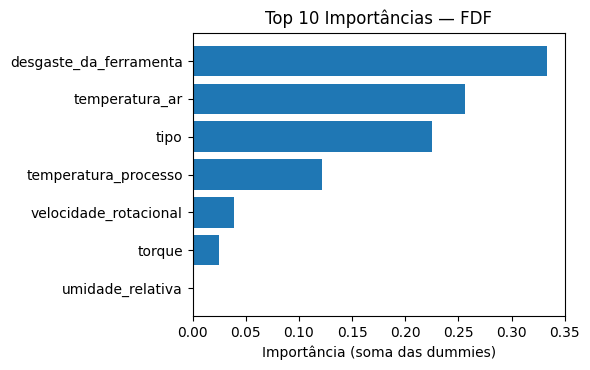

Figura salva: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/top10_importancias_FDF.png


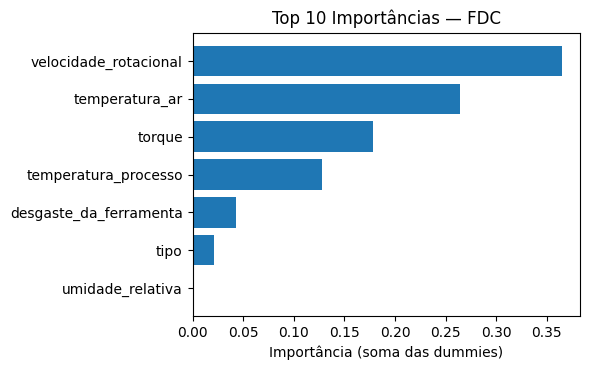

Figura salva: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/top10_importancias_FDC.png


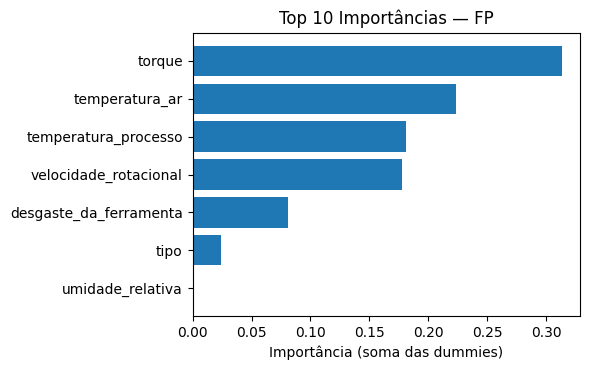

Figura salva: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/top10_importancias_FP.png


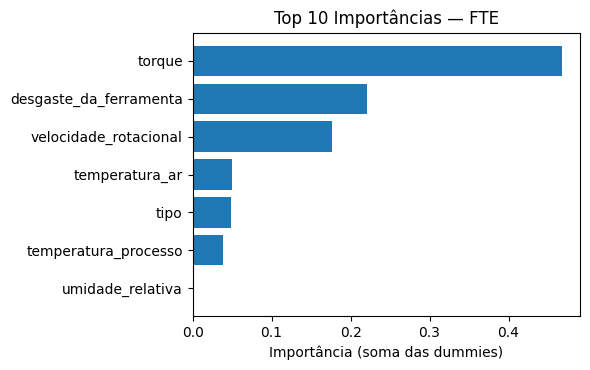

Figura salva: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/top10_importancias_FTE.png


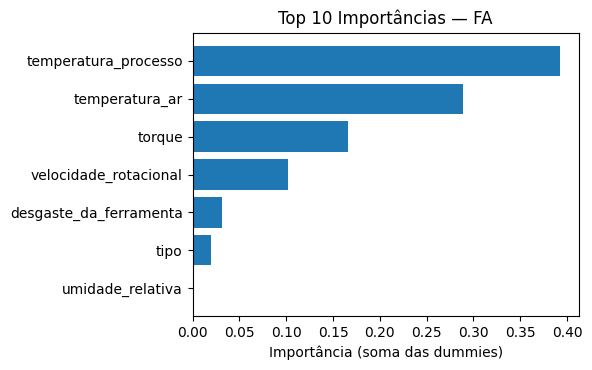

Figura salva: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results/plots/top10_importancias_FA.png


,feature_orig,importance
4,torque,4.671123e-01
0,desgaste_da_ferramenta,2.205181e-01
6,velocidade_rotacional,1.759221e-01
1,temperatura_ar,5.018688e-02
3,tipo,4.827165e-02
2,temperatura_processo,3.798826e-02
5,umidade_relativa,6.179185e-07


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

moc = clf.named_steps['clf']  # MultiOutputClassifier
os.makedirs(PLOTS_DIR, exist_ok=True)

all_importances = {}  # guarda tabelas por rótulo

for i, label in enumerate(['FDF','FDC','FP','FTE','FA']):
    rf_i = moc.estimators_[i]  # RandomForest desse rótulo
    importances = rf_i.feature_importances_
    # DataFrame com importâncias por coluna transformada
    imp_df = pd.DataFrame({
        "feature_transf": feat_names_out,
        "importance": importances
    })
    # Agregar por coluna original (somando dummies da mesma coluna)
    imp_df["feature_orig"] = imp_df["feature_transf"].map(orig_map)
    agg = imp_df.groupby("feature_orig", as_index=False)["importance"].sum()
    agg = agg.sort_values("importance", ascending=False)

    all_importances[label] = agg  # guarda tabela completa

    # Plot Top 10
    topk = agg.head(10).sort_values("importance", ascending=True)
    plt.figure(figsize=(6,3.8))
    plt.barh(topk["feature_orig"], topk["importance"])
    plt.title(f"Top 10 Importâncias — {label}")
    plt.xlabel("Importância (soma das dummies)")
    plt.tight_layout()
    out_path = f"{PLOTS_DIR}/top10_importancias_{label}.png"
    plt.savefig(out_path, dpi=120, bbox_inches="tight")
    plt.show()

    print(f"Figura salva: {out_path}")

# Visualiza tabela de uma falha como exemplo
all_importances['FTE'].head(15)

In [90]:
# Salva uma planilha por rótulo
for label, df_imp in all_importances.items():
    df_imp.to_csv(f"{RESULTS_DIR}/importancias_{label}.csv", index=False)

# Também salva uma tabela "longa" com todas as falhas empilhadas
imp_long = []
for label, df_imp in all_importances.items():
    tmp = df_imp.copy()
    tmp["label"] = label
    imp_long.append(tmp)
imp_long = pd.concat(imp_long, ignore_index=True)
imp_long = imp_long[["label","feature_orig","importance"]].sort_values(["label","importance"], ascending=[True, False])
imp_long.to_csv(f"{RESULTS_DIR}/importancias_todas_labels.csv", index=False)

print("Arquivos salvos em:", RESULTS_DIR)

Arquivos salvos em: /content/drive/MyDrive/Projeto_Manutencao_Preditiva/results
